# Melbourne Solar Data Project
By Brian Robinson

## Executive Summary

From the analysis below we find that solar adoption is not influenced by property characteristics like price, distance from CBD or number of rooms but much more likely to be influenced by the age of the house. There are likely to be other factors which could even have a stronger influence, it is recommended that for further analysis the demographic characteristics of the buyer should be analysed using ABS data.

## Introduction

Melbourne has experienced significant growth in residential solar installations over the past decade, positioning itself as a leader in Australia's renewable energy transition. This report will examine which, if any, property characteristics are likely to influence solar adoption.
This analysis links property characteristics from house sales data with solar sales data to compare solar adoption across Melbourne's diverse housing market. 


## Initial Exploration - Core Data Sets


### Import the libraries

In [265]:
import pandas as pd
import seaborn as sns

### List File Content

In [266]:
%ls "C:/Users/Brian/OneDrive/Desktop/Data Project 2/data"



 Volume in drive C has no label.
 Volume Serial Number is 9A8D-F216

 Directory of C:\Users\Brian\OneDrive\Desktop\Data Project 2\data

25/06/2025  13:46    <DIR>          .
25/06/2025  13:46    <DIR>          ..
03/06/2025  11:16         8,793,303 australian_postcodes.csv
03/06/2025  11:16             1,666 data-dict.md
03/06/2025  11:16         7,296,418 MELBOURNE_HOUSE_PRICES_LESS.csv
03/06/2025  11:16         5,018,236 Melbourne_housing_FULL.csv
25/06/2025  13:46         1,108,126 POA_2021_AUST_GDA2020.dbf
25/06/2025  13:46               137 POA_2021_AUST_GDA2020.prj
25/06/2025  13:44        79,677,528 POA_2021_AUST_GDA2020.shp
25/06/2025  13:46            21,252 POA_2021_AUST_GDA2020.shx
03/06/2025  11:16         2,099,089 sgu-solar-capacity-2011-to-present.csv
03/06/2025  11:16         1,025,401 sgu-solar-installations-2011-to-present.csv
              10 File(s)    105,041,156 bytes
               2 Dir(s)  621,052,829,696 bytes free


### Read the house prices dataset into a dataframe

The house data is contained in two main datasets:
- `MELBOURNE_HOUSE_PRICES_LESS.csv`: Core house sales data for Melbourne
- `Melbourne_housing_FULL.csv`: Extended dataset containing house age information
Let's start by setting up our data path and loading the datasets.

### Initial Data Inspection

Let's examine the structure of our datasets to understand what information we're working with.

In [267]:
data_path = "C:/Users/Brian/OneDrive/Desktop/Data Project 2/data"


In [268]:
import os
os.chdir(data_path)


In [269]:
df = pd.read_csv('MELBOURNE_HOUSE_PRICES_LESS.csv')
age_df = pd.read_csv('Melbourne_housing_FULL.csv')

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         63023 non-null  object 
 1   Address        63023 non-null  object 
 2   Rooms          63023 non-null  int64  
 3   Type           63023 non-null  object 
 4   Price          48433 non-null  float64
 5   Method         63023 non-null  object 
 6   SellerG        63023 non-null  object 
 7   Date           63023 non-null  object 
 8   Postcode       63023 non-null  int64  
 9   Regionname     63023 non-null  object 
 10  Propertycount  63023 non-null  int64  
 11  Distance       63023 non-null  float64
 12  CouncilArea    63023 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 6.3+ MB


In [271]:
age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

## Cleaning the data 

### House Data

#### Convert postcode to string

Postcodes in the dataset are inconsistent - some are integers, some floats, and some may have leading zeros missing. We need to standardize them to 4-digit strings for consistent matching with the solar data later.

Steps:
1. Remove rows with missing postcodes
2. Convert to standardized 4-digit string format (e.g., "3000" instead of "3000.0" or "3000")

In [272]:
df['Postcode'] = df['Postcode'].astype(str).str.strip().str.zfill(4)
age_df = age_df[age_df['Postcode'].notna()]
age_df['Postcode'] = age_df['Postcode'].astype(float).astype(int).astype(str).str.zfill(4)


#### Drop all rows where price is missing

In [273]:
df = df.dropna(subset=['Price'])
age_df = age_df.dropna(subset=['Price'])

#### Add the year built info by merging

In [274]:
df = df.merge(age_df[['Address', 'Postcode', 'YearBuilt']], 
              on=['Address','Postcode'], 
              how='left')

In [275]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Postcode', 'Regionname', 'Propertycount', 'Distance',
       'CouncilArea', 'YearBuilt'],
      dtype='object')

### Data Quality Check - Year Built

Let's examine the year built data for any anomalies or outliers that need cleaning.

In [276]:
df.YearBuilt.describe()

count    13382.000000
mean      1966.920117
std         36.687047
min       1196.000000
25%       1950.000000
50%       1970.000000
75%       2000.000000
max       2019.000000
Name: YearBuilt, dtype: float64

In [277]:
# Clear the erroneous 1196
df = df[df['YearBuilt'] != 1196]


In [278]:
df.YearBuilt.describe()

count    13381.000000
mean      1966.977730
std         36.077948
min       1820.000000
25%       1950.000000
50%       1970.000000
75%       2000.000000
max       2019.000000
Name: YearBuilt, dtype: float64

#### From the year built column we create an age column

In [279]:
from datetime import datetime

# Current year
current_year = datetime.now().year

# Create Age column with basic subtraction
df['Age'] = current_year - df['YearBuilt']

# Replace invalid values (negative or null ages) with NaN
df.loc[(df['Age'] < 0) | (df['YearBuilt'].isna()), 'Age'] = pd.NA


#### Convert dates to month 

In [280]:
df.Date = df.Date.astype(str)
df.Date = pd.to_datetime(df.Date, format='%d/%m/%Y').dt.to_period('M')

### Solar Data

#### Read solar cap and solar units data 

Now let's load our solar datasets. We have two complementary datasets:
- Solar capacity data: Information about the total solar capacity installed
- Solar installations data: Information about the number of solar installations

Both datasets cover the period from 2011 to present and will help us understand solar adoption patterns across Melbourne.

In [281]:
df_solar_cap = pd.read_csv('sgu-solar-capacity-2011-to-present.csv')

df_solar_units = pd.read_csv('sgu-solar-installations-2011-to-present.csv')


### Examine the Solar Cap columns 

In [282]:
df_solar_cap.columns

Index(['Small Unit Installation Postcode', 'Jan 2011 - SGU Rated Output In kW',
       'Feb 2011 - SGU Rated Output In kW',
       'Mar 2011 - SGU Rated Output In kW',
       'Apr 2011 - SGU Rated Output In kW',
       'May 2011 - SGU Rated Output In kW',
       'Jun 2011 - SGU Rated Output In kW',
       'Jul 2011 - SGU Rated Output In kW',
       'Aug 2011 - SGU Rated Output In kW',
       'Sep 2011 - SGU Rated Output In kW',
       ...
       'Jul 2023 - SGU Rated Output In kW',
       'Aug 2023 - SGU Rated Output In kW',
       'Sep 2023 - SGU Rated Output In kW',
       'Oct 2023 - SGU Rated Output In kW',
       'Nov 2023 - SGU Rated Output In kW',
       'Dec 2023 - SGU Rated Output In kW',
       'Jan 2024 - SGU Rated Output In kW',
       'Feb 2024 - SGU Rated Output In kW',
       'Mar 2024 - SGU Rated Output In kW',
       'Apr 2024 - SGU Rated Output In kW'],
      dtype='object', length=161)

#### Rename columns

In [283]:
df_solar_cap.rename(columns={'Small Unit Installation Postcode': 'Postcode'}, inplace=True)
df_solar_units.rename(columns={'Small Unit Installation Postcode': 'Postcode'}, inplace=True)

#### Standardise postcode to 4 digit format

In [284]:
df_solar_cap.Postcode = df_solar_cap.Postcode.astype(str).str.zfill(4)
df_solar_units.Postcode = df_solar_units.Postcode.astype(str).str.zfill(4)

#### Unpivot the data

In [285]:
def solar_melter(df, value_var, id_var='Postcode', splitter=' - '):
    """
    Melt the solar data frame to have a 'Date' and 'kW' column.
    """
    df_melted = df.melt(id_vars=[id_var], var_name='Date', value_name=value_var)
    # convert Date to period (M):
    df_melted['Date'] = df_melted['Date'].str.split(splitter).str[0]
    df_melted['Date'] = pd.to_datetime(df_melted['Date'], format='%b %Y').dt.to_period('M')
    return df_melted
df_solar_cap_melted = solar_melter(df_solar_cap, 'kW')
df_solar_units_melted = solar_melter(df_solar_units, 'Units')

In [286]:
df_solar_cap_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449440 entries, 0 to 449439
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype    
---  ------    --------------   -----    
 0   Postcode  449440 non-null  object   
 1   Date      449440 non-null  period[M]
 2   kW        449440 non-null  float64  
dtypes: float64(1), object(1), period[M](1)
memory usage: 10.3+ MB


#### Check for duplicates

In [287]:
df_solar_units_melted.duplicated(subset=['Postcode', 'Date']).sum()


0

#### Merge the solar cap and solar units into one dataframe

In [288]:
df_solar_combined = pd.merge(df_solar_cap_melted, df_solar_units_melted, on=['Postcode', 'Date'], how='outer')


In [289]:
df_solar_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449440 entries, 0 to 449439
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype    
---  ------    --------------   -----    
 0   Postcode  449440 non-null  object   
 1   Date      449440 non-null  period[M]
 2   kW        449440 non-null  float64  
 3   Units     449440 non-null  int64    
dtypes: float64(1), int64(1), object(1), period[M](1)
memory usage: 13.7+ MB


## Merge solar with housing data and group the data

### Get dummy variables for the property type

In [290]:
df = pd.concat([pd.get_dummies(df.Type, prefix='Count',), df], axis=1)

### Group by date and postcode to form monthly sales

In [291]:
df_monthly_sales = df.groupby(['Postcode', 'Date']).agg({
    'Price': 'mean',
    'Rooms': 'mean',
    'Distance': 'mean',
    'Age': 'mean',
    'Propertycount': 'max',
    'Count_h': 'sum',
    'Count_t': 'sum',
    'Count_u': 'sum'
    
    }
).reset_index()

In [292]:
df_monthly_sales.Count_h.describe()

count    5231.000000
mean        6.608488
std         6.189150
min         0.000000
25%         2.000000
50%         5.000000
75%         9.000000
max        47.000000
Name: Count_h, dtype: float64

### Aggregate the property type dummies

In [293]:
grouped_by_type = df_monthly_sales.groupby('Postcode').agg({'Count_u': 'sum',
    'Count_t': 'sum',
    'Count_h': 'sum'})


In [294]:
grouped_by_type.head()

Count_u  Count_t  Count_h
Postcode                           
3000          208        0        1
3002           37        1       13
3003           31       14       20
3006           84        0        3
3008            8        1        0

### Merge the solar dataframe with the monthly house sales dataframe

In [295]:
df_merged = pd.merge(df_monthly_sales, df_solar_combined, on=['Postcode','Date'], how='left', validate='1:1')


In [296]:
df_merged.head()

Postcode     Date         Price     Rooms  Distance   Age  Propertycount  \
0     3000  2016-02  5.200000e+05  2.000000       0.0   NaN          17496   
1     3000  2016-04  6.002500e+05  1.750000       0.0   NaN          17496   
2     3000  2016-05  7.571250e+05  2.375000       0.0  26.0          17496   
3     3000  2016-06  1.131857e+06  2.285714       0.0  28.0          17496   
4     3000  2016-07  6.221667e+05  2.000000       0.0  13.0          17496   

   Count_h  Count_t  Count_u     kW  Units  
0        0        0        1   10.4      1  
1        0        0        4    0.0      0  
2        0        0        8    0.0      0  
3        0        0        7    0.0      0  
4        0        0        6  100.8      2

### Group by postcode

In [297]:
df_grouped = df_merged.groupby('Postcode').agg({
    'Price': 'mean',
    'Age' : 'mean',
    'kW': 'sum',
    'Units': 'sum',
    'Rooms': 'mean',
    'Distance': 'mean',
    'Propertycount': 'max',
    
    
}).reset_index()

In [298]:
df_grouped.head()

Postcode         Price        Age       kW  Units     Rooms  Distance  \
0     3000  7.626089e+05  36.687363  472.300     16  1.971054       0.0   
1     3002  1.508702e+06  52.785714   66.585     11  2.039394       1.3   
2     3003  9.795298e+05  58.467949  602.540     20  2.419772       3.1   
3     3006  6.311283e+05  24.501190   55.260      4  1.950667       0.7   
4     3008  6.561250e+05        NaN  142.760      3  2.062500       1.4   

   Propertycount  
0          17496  
1           3040  
2           2230  
3           8400  
4           4707

### Add the dummies to the dataframe

In [299]:
df_grouped_with_dummies  = pd.merge(df_grouped, grouped_by_type, on=['Postcode'], how='left', validate='1:1')

In [300]:
df_grouped_with_dummies.head()

Postcode         Price        Age       kW  Units     Rooms  Distance  \
0     3000  7.626089e+05  36.687363  472.300     16  1.971054       0.0   
1     3002  1.508702e+06  52.785714   66.585     11  2.039394       1.3   
2     3003  9.795298e+05  58.467949  602.540     20  2.419772       3.1   
3     3006  6.311283e+05  24.501190   55.260      4  1.950667       0.7   
4     3008  6.561250e+05        NaN  142.760      3  2.062500       1.4   

   Propertycount  Count_u  Count_t  Count_h  
0          17496      208        0        1  
1           3040       37        1       13  
2           2230       31       14       20  
3           8400       84        0        3  
4           4707        8        1        0

### Add some additional fields

In [301]:
# additional features
import numpy as np

# Create features
df_grouped_with_dummies['units_per_property'] = df_grouped_with_dummies['Units'] / df_grouped_with_dummies['Propertycount']
df_grouped_with_dummies['kW_per_unit'] = df_grouped['kW'] / df_grouped_with_dummies['Units']






In [302]:
# We will use house ratio to estimate the number of houses
df_grouped_with_dummies['total'] = df_grouped_with_dummies.iloc[:, -3:].sum(axis=1)
df_grouped_with_dummies['houses_ratio'] = (df_grouped_with_dummies.Count_h + df_grouped_with_dummies.Count_t)/df_grouped_with_dummies.total


In [303]:
# houses ratio multiply by property count to give an estimate of number of houses
df_grouped_with_dummies['estimated_houses'] = df_grouped_with_dummies.houses_ratio*df_grouped_with_dummies.Propertycount
# Then get units per house
df_grouped_with_dummies['units_per_house'] = df_grouped_with_dummies.Units/df_grouped_with_dummies.estimated_houses

In [304]:
# Replace inf/-inf with NaN
df_grouped_with_dummies.replace([np.inf, -np.inf], np.nan, inplace=True)

In [305]:
df_grouped_with_dummies.head()

Postcode         Price        Age       kW  Units     Rooms  Distance  \
0     3000  7.626089e+05  36.687363  472.300     16  1.971054       0.0   
1     3002  1.508702e+06  52.785714   66.585     11  2.039394       1.3   
2     3003  9.795298e+05  58.467949  602.540     20  2.419772       3.1   
3     3006  6.311283e+05  24.501190   55.260      4  1.950667       0.7   
4     3008  6.561250e+05        NaN  142.760      3  2.062500       1.4   

   Propertycount  Count_u  Count_t  Count_h  units_per_property  kW_per_unit  \
0          17496      208        0        1            0.000914    29.518750   
1           3040       37        1       13            0.003618     6.053182   
2           2230       31       14       20            0.008969    30.127000   
3           8400       84        0        3            0.000476    13.815000   
4           4707        8        1        0            0.000637    47.586667   

       total  houses_ratio  estimated_houses  units_per_house  
0  30.519664      0.032766        573.269736         0.027910  
1  19.056800      0.734646       2233.323510         0.004925  
2  50.135969      0.678156       1512.287527         0.013225  
3  16.815476      0.178407       1498.619469         0.002669  
4  47.587304      0.021014         98.912937         0.030330

In [306]:
# Drop the unnecessary dummies now that we don't need them.
df_grouped = df_grouped_with_dummies.drop(['Count_u', 'Count_t', 'Count_h', 'total', 'estimated_houses'], axis=1, inplace=False)

In [307]:
# We will work with this df which contains all we need.
df_grouped.head()

Postcode         Price        Age       kW  Units     Rooms  Distance  \
0     3000  7.626089e+05  36.687363  472.300     16  1.971054       0.0   
1     3002  1.508702e+06  52.785714   66.585     11  2.039394       1.3   
2     3003  9.795298e+05  58.467949  602.540     20  2.419772       3.1   
3     3006  6.311283e+05  24.501190   55.260      4  1.950667       0.7   
4     3008  6.561250e+05        NaN  142.760      3  2.062500       1.4   

   Propertycount  units_per_property  kW_per_unit  houses_ratio  \
0          17496            0.000914    29.518750      0.032766   
1           3040            0.003618     6.053182      0.734646   
2           2230            0.008969    30.127000      0.678156   
3           8400            0.000476    13.815000      0.178407   
4           4707            0.000637    47.586667      0.021014   

   units_per_house  
0         0.027910  
1         0.004925  
2         0.013225  
3         0.002669  
4         0.030330

## Initial Exporation

### Expected Solar Capacity Patterns

For solar installation capacity, we might expect:
- **Larger homes (more rooms)** to install higher capacity systems due to:
  - Greater roof space available
  - Higher energy consumption needs
  - More disposable income for larger investments
- **More expensive houses** to potentially have higher capacity systems due to:
  - richer owners being able to afford the cost of solar panels
  
Let's test these hypotheses with our data.

### Pairplots

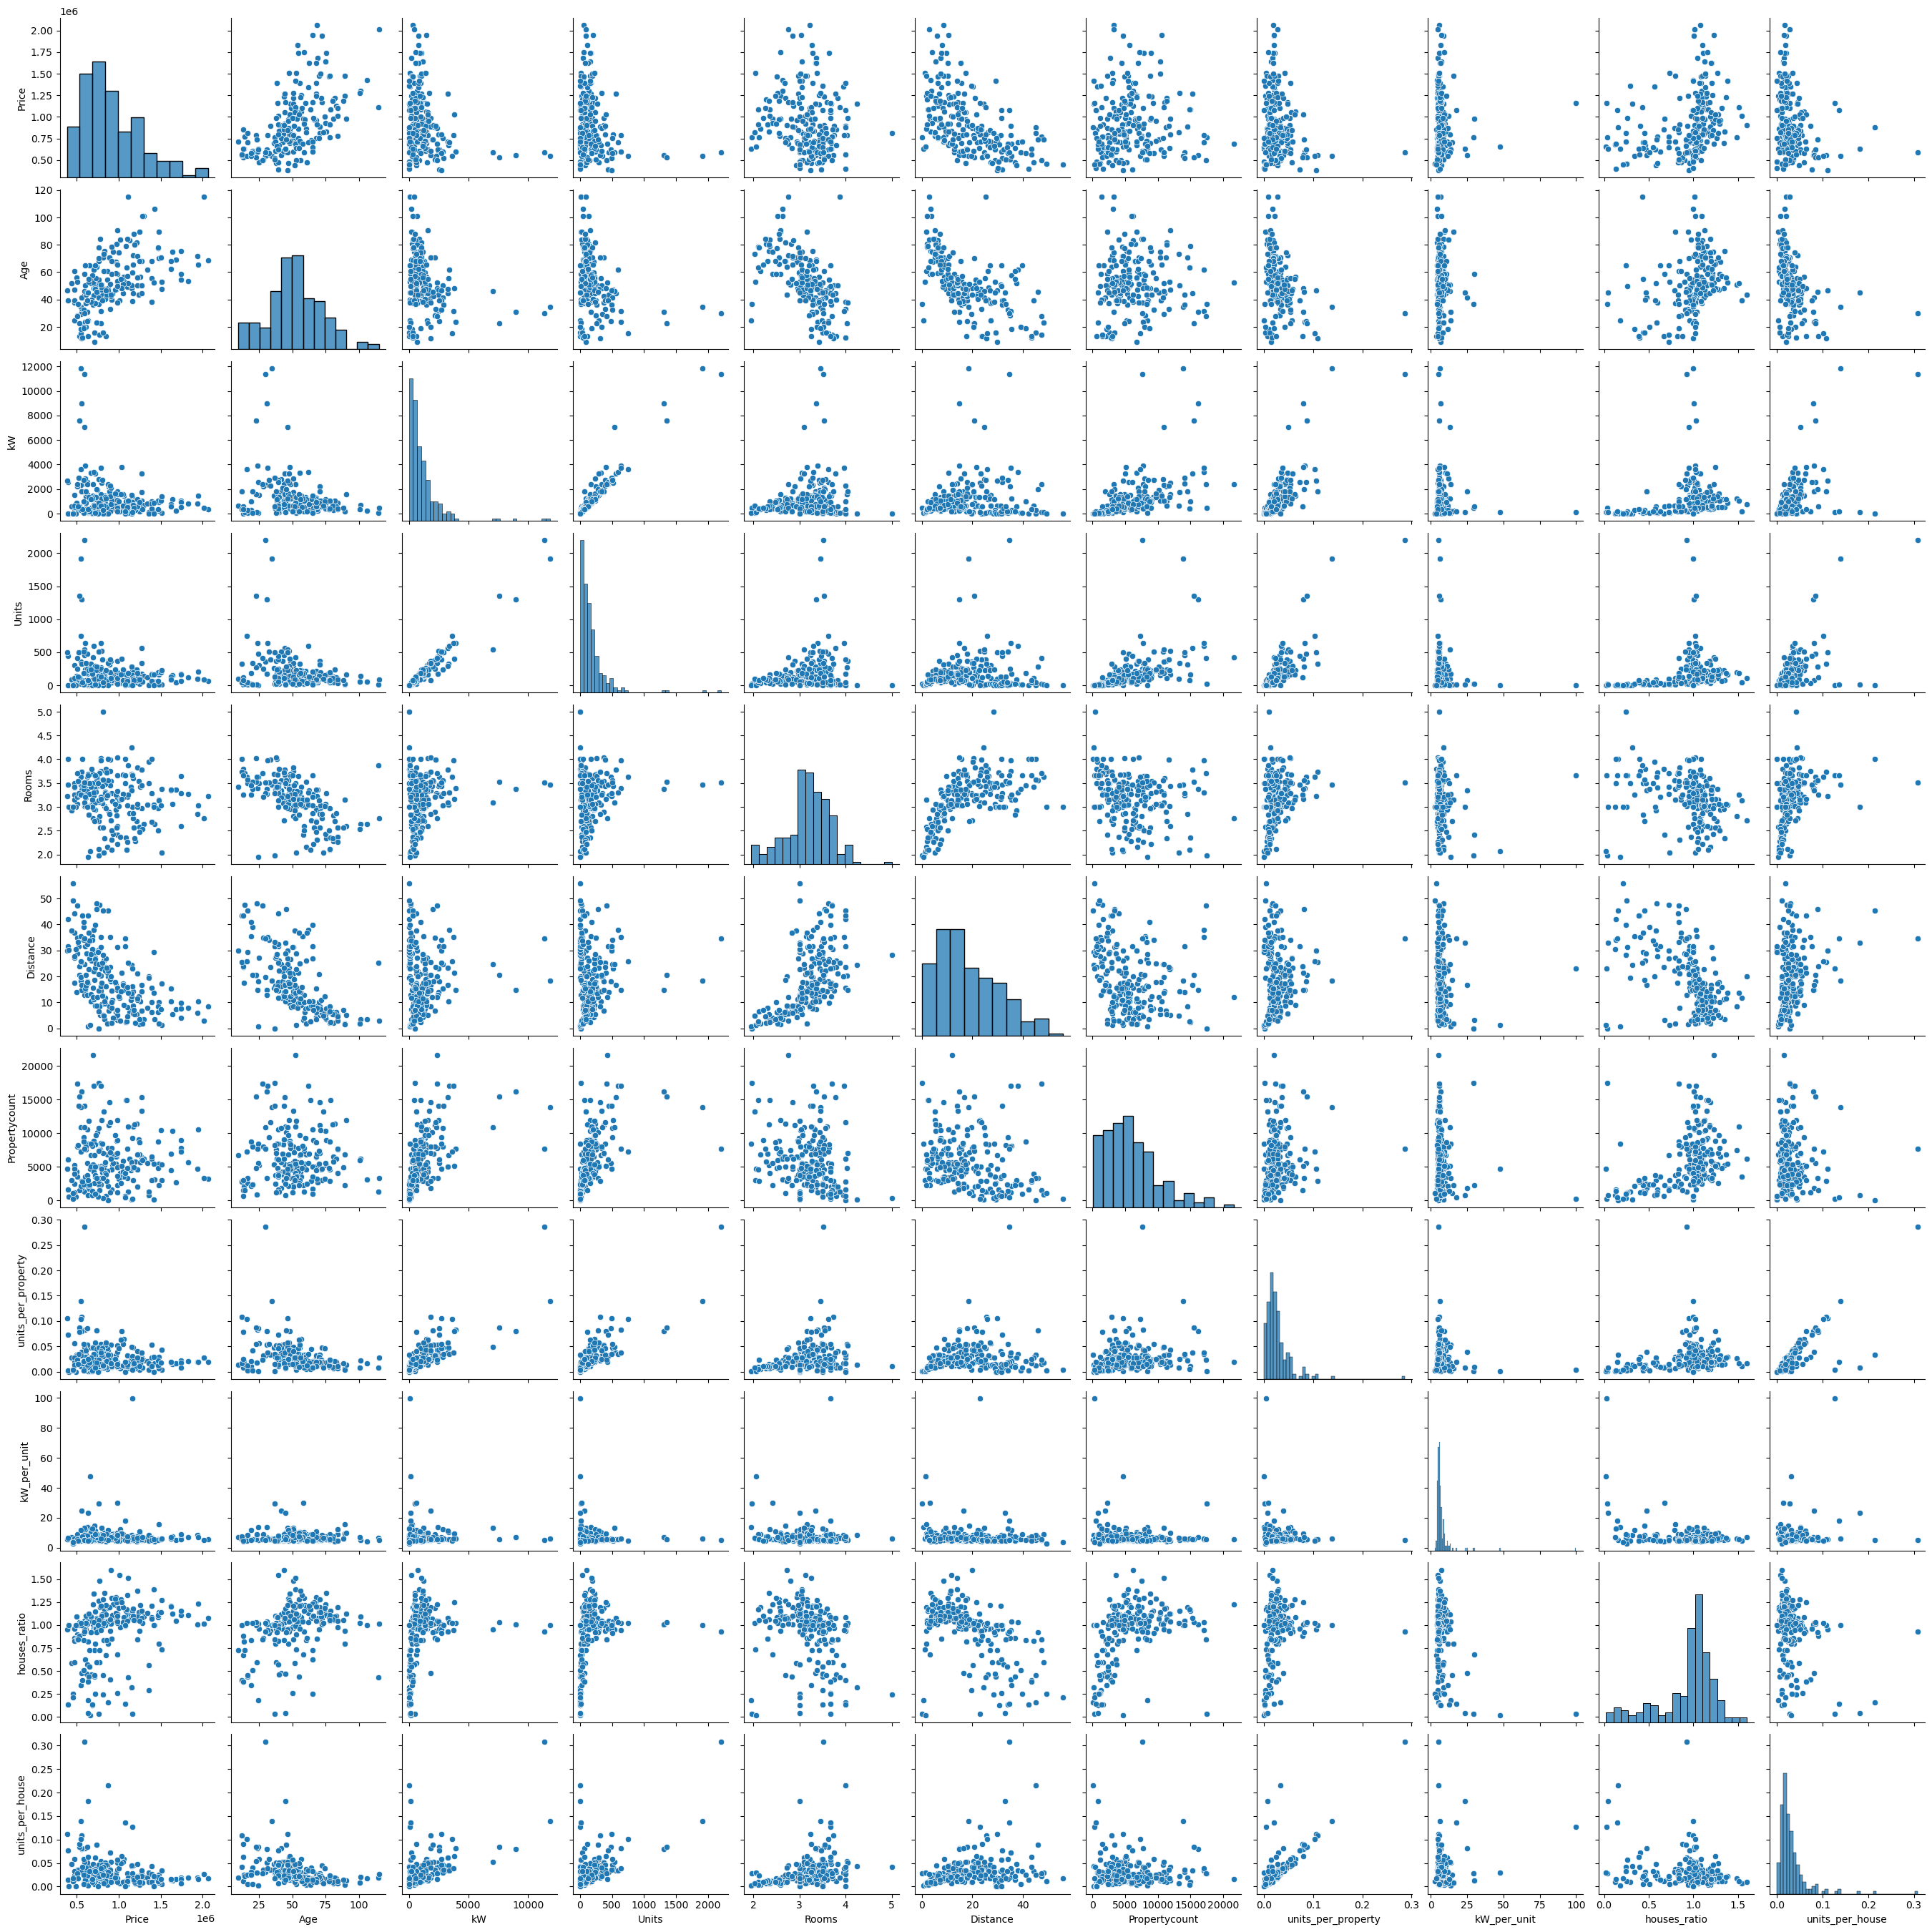

In [308]:
import matplotlib.pyplot as plt
sns.pairplot(df_grouped.select_dtypes(include=['number']))


### Heatmap

<Axes: >

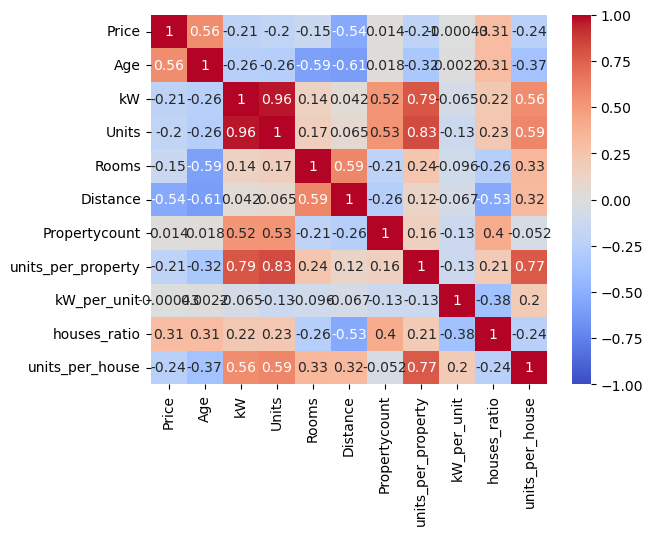

In [309]:
sns.heatmap(df_grouped.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

## Expectations versus reality.

### Key Learning: The Complexity of Solar Adoption

The fact that our predictions were inaccurate highlights an important principle in data analysis - **multiple factors often interact in unexpected ways**. 

## Next Steps

Based on our initial exploration and data cleaning, we have established our datasets and formed hypotheses about factors influencing solar adoption in Melbourne. The next phase requires systematic analysis to test these hypotheses and identify the true drivers of solar adoption.

### Proposed framework

*Clustering Analysis for Suburb Categorization*

We will standardize our dataset and implement k-means clustering to categorize Melbourne suburbs into 3-5 distinct groups based on their solar adoption characteristics. This unsupervised approach will help identify natural patterns in the data that may not be immediately apparent through traditional correlation analysis.

*Geographic Visualization and Pattern Recognition*

By incorporating geographic shapefiles and mapping our clustered suburbs with color-coded categories, we can visually assess whether solar adoption patterns follow geographic boundaries. If neighboring suburbs consistently fall into similar categories, this would suggest that geographic factors (such as local policies, installer networks, or community influence) play a significant role in solar adoption decisions.





## Now we will perform scaling and clustering

In [331]:
# Imports
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize

### Winsorise the data to remove the influence of outliers and scale the result

In [333]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler


os.environ["OMP_NUM_THREADS"] = "1"

# Create a copy of the dataframe
df_processed = df_grouped.copy()

# Get numeric columns
numeric_cols = df_processed.select_dtypes(include=['number']).columns

# Winsorize the numeric columns (clips extreme values)
# limits=(0.05, 0.05) means clip bottom 5% and top 5% of values
for col in numeric_cols:
    df_processed[col] = winsorize(df_processed[col], limits=(0.05, 0.05))

# Scale the winsorized data
scaler = StandardScaler()
df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])

print("Data has been winsorized and scaled")

Data has been winsorized and scaled


In [341]:
# Ensure that there are no null values in our scaled df.
df_processed = df_processed.dropna()

<!-- ### Scale the data -->

In [342]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, 0 to 219
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Postcode            199 non-null    object 
 1   Price               199 non-null    float64
 2   Age                 199 non-null    float64
 3   kW                  199 non-null    float64
 4   Units               199 non-null    float64
 5   Rooms               199 non-null    float64
 6   Distance            199 non-null    float64
 7   Propertycount       199 non-null    float64
 8   units_per_property  199 non-null    float64
 9   kW_per_unit         199 non-null    float64
 10  houses_ratio        199 non-null    float64
 11  units_per_house     199 non-null    float64
dtypes: float64(11), object(1)
memory usage: 20.2+ KB


### Now to find the optimum number of Clusters

#### Plotting the inertia for the elbow method

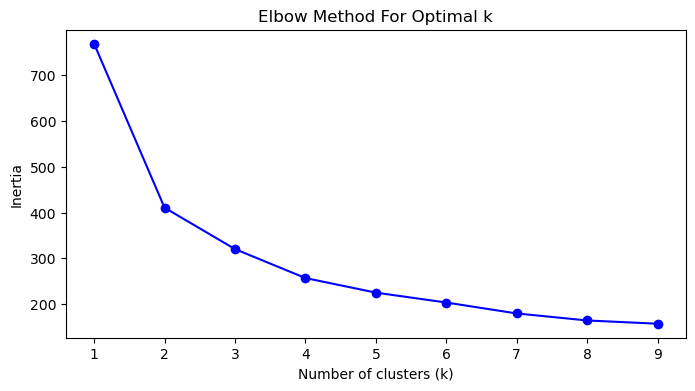

In [343]:
import os
import warnings
import matplotlib.pyplot as plt  

os.environ["OMP_NUM_THREADS"] = "1"
warnings.filterwarnings('ignore') # Stops the warning about memory leaks
from sklearn.cluster import KMeans

k_values = range(1, 10)
inertia = []


features = df_processed[['Price', 'Rooms','Age', 'Distance']]
features = features.dropna()

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_values)
plt.show()

#### Silhouette Scores

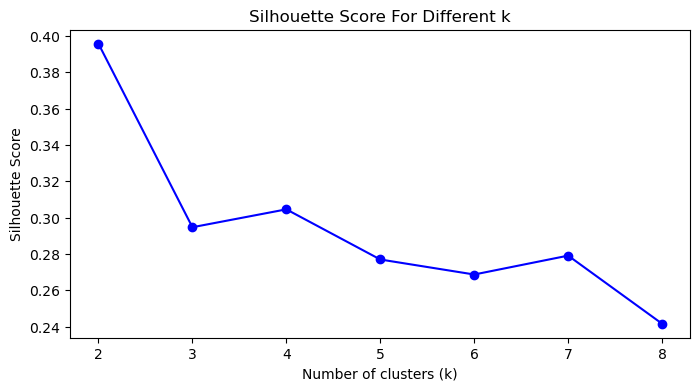

In [344]:
from sklearn.metrics import silhouette_score

k_values = range(2, 9)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Different k')
plt.xticks(k_values)
plt.show()

Let us try k = 4 clusters based on the silhouette scores and inertia plots

#### PCA Plot

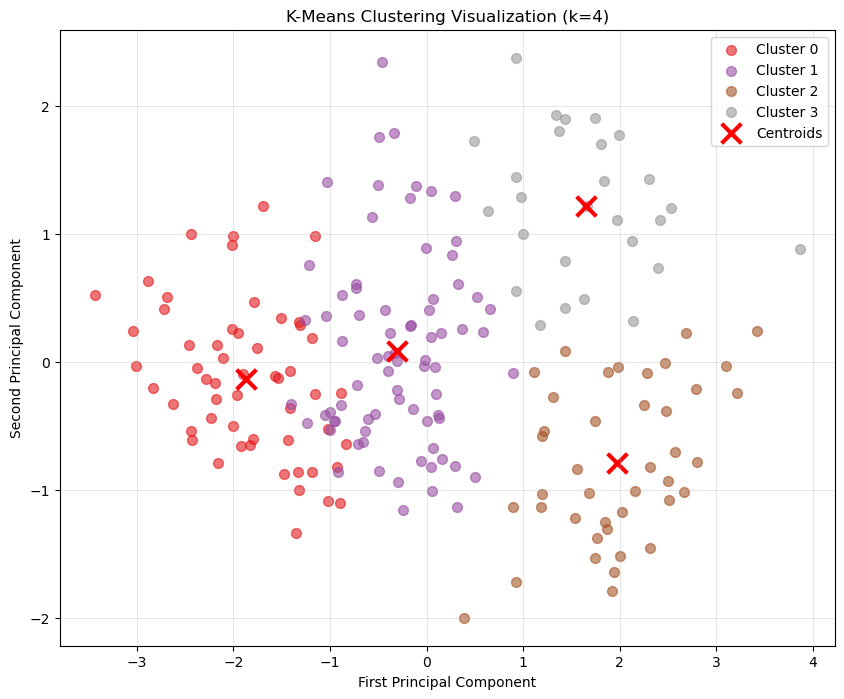

Explained variance ratio: [0.65554115 0.19799958]
Total explained variance: 0.854


In [345]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Reduce to 2D for visualization
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Run KMeans with your chosen k (adjust as needed)
k = 4  # Change this to your preferred k value
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Transform cluster centers to 2D space
cluster_centers_2d = pca.transform(kmeans.cluster_centers_)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot points colored by cluster
colors = plt.cm.Set1(np.linspace(0, 1, k))
for i in range(k):
    mask = cluster_labels == i
    plt.scatter(features_2d[mask, 0], features_2d[mask, 1], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=50)

# Plot cluster centers
plt.scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1], 
           c='red', marker='x', s=200, linewidth=3, label='Centroids')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'K-Means Clustering Visualization (k={k})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print explained variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.3f}")

Now lets try mapping the clusters to see what they represent.

## Mapping and visualisation

In [346]:

pip install folium

### Import the shapefile from ABS using Geopandas and merge with our scaled df

In [348]:
import geopandas as gpd
import pandas as pd

# Load the shapefile
gdf = gpd.read_file('POA_2021_AUST_GDA2020.shp')

# Reproject to WGS84 if needed
if gdf.crs != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)


# Merge on postcode - this is your requested df
merged_df = gdf.merge(df_processed, left_on='POA_CODE21', right_on='Postcode', how='inner')

print(f"Merged dataset shape: {merged_df.shape}")

Merged dataset shape: (199, 21)


### Plotting the clusters on a map using Folium

In [349]:
import folium
from folium import plugins
import pandas as pd

def create_cluster_map(merged_df, cluster_labels, k=4):
    """
    Create a Folium map showing K-means clusters on Melbourne postcodes
    
    Parameters:
    - merged_df: Your GeoDataFrame with geometry and postcode data
    - cluster_labels: Array of cluster labels from your K-means
    - k: Number of clusters
    """
    
    # Add cluster labels to the merged dataframe
    df_with_clusters = merged_df.copy()
    df_with_clusters['Cluster'] = cluster_labels
    
    print(f"Creating map with {k} clusters for {len(df_with_clusters)} postcodes")
    
    # Calculate map center from the data bounds
    bounds = df_with_clusters.total_bounds
    map_center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]
    
    # Create the base map
    m = folium.Map(
        location=map_center,
        zoom_start=10,
        tiles='CartoDB positron'
    )
    
    # Define colors for clusters (matching your matplotlib colors)
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
    cluster_colors = colors[:k]
    
    # Add each cluster as a separate layer
    for cluster_id in range(k):
        cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
        
        if len(cluster_data) == 0:
            continue
            
        # Create a feature group for this cluster
        cluster_group = folium.FeatureGroup(name=f'Cluster {cluster_id} ({len(cluster_data)} postcodes)')
        
        # Add each postcode in this cluster
        for idx, row in cluster_data.iterrows():
            # Create popup content with postcode info
            popup_content = f"""
            <div style="font-family: Arial; width: 200px;">
                <h4 style="margin-bottom: 10px; color: {cluster_colors[cluster_id]};">
                    Cluster {cluster_id}
                </h4>
                <table style="width: 100%; font-size: 12px;">
                    <tr><td><b>Postcode:</b></td><td>{row['POA_CODE21']}</td></tr>
                    <tr><td><b>Suburb:</b></td><td>{row.get('POA_NAME21', 'N/A')}</td></tr>
                    <tr><td><b>Price:</b></td><td>${row.get('Price', 0):,.0f}</td></tr>
                    <tr><td><b>Solar kW:</b></td><td>{row.get('kW', 0):.1f}</td></tr>
                    <tr><td><b>Properties:</b></td><td>{row.get('Propertycount', 0):,.0f}</td></tr>
                    <tr><td><b>Distance:</b></td><td>{row.get('Distance', 0):.1f} km</td></tr>
                </table>
            </div>
            """
            
            # Create tooltip content
            tooltip_content = f"Postcode: {row['POA_CODE21']} | Cluster: {cluster_id}"
            
            # Add the postcode area to the cluster group
            folium.GeoJson(
                row['geometry'],
                style_function=lambda feature, color=cluster_colors[cluster_id]: {
                    'fillColor': color,
                    'color': 'black',
                    'weight': 1,
                    'fillOpacity': 0.7,
                },
                highlight_function=lambda feature: {
                    'weight': 3,
                    'fillOpacity': 0.9,
                },
                popup=folium.Popup(popup_content, max_width=250),
                tooltip=tooltip_content
            ).add_to(cluster_group)
        
        # Add the cluster group to the map
        cluster_group.add_to(m)
    
    # Add cluster statistics as a custom legend
    legend_html = f'''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 200px; height: auto; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <h4 style="margin-top:0">Cluster Distribution</h4>
    '''
    
    for cluster_id in range(k):
        cluster_count = len(df_with_clusters[df_with_clusters['Cluster'] == cluster_id])
        legend_html += f'''
        <p><i class="fa fa-square" style="color:{cluster_colors[cluster_id]}"></i> 
        Cluster {cluster_id}: {cluster_count} postcodes</p>
        '''
    
    legend_html += '</div>'
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add alternative tile layers
    folium.TileLayer('OpenStreetMap').add_to(m)
    folium.TileLayer('CartoDB dark_matter').add_to(m)
    
    # Add layer control
    folium.LayerControl(collapsed=False).add_to(m)
    
    # Add fullscreen button
    plugins.Fullscreen().add_to(m)
    
    # Fit map to data bounds
    m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])
    
    # Print cluster summary
    print("\nCluster Summary:")
    print("-" * 40)
    for cluster_id in range(k):
        cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
        if len(cluster_data) > 0:
            avg_price = cluster_data['Price'].mean()
            avg_distance = cluster_data['Distance'].mean()
            avg_kw = cluster_data['kW'].mean()
            print(f"Cluster {cluster_id}: {len(cluster_data)} postcodes")
            print(f"  Avg Price: ${avg_price:,.0f}")
            print(f"  Avg Distance: {avg_distance:.1f} km")
            print(f"  Avg Solar: {avg_kw:.1f} kW")
            print(f"  Sample postcodes: {cluster_data['POA_CODE21'].head(3).tolist()}")
            print()
    
    return m, df_with_clusters

# Usage example:
# Assuming you have:
# - merged_df: your GeoDataFrame with geometry and postcode data
# - cluster_labels: your K-means cluster labels
# - k: number of clusters (you used k=4)

# Create the cluster map
# m, df_with_clusters = create_cluster_map(merged_df, cluster_labels, k=4)

# Display the map
# m

# Optional: Save the map
# m.save('melbourne_clusters_map.html')
# print("Map saved to melbourne_clusters_map.html")

print("To use this code:")
print("1. Make sure you have your merged_df (GeoDataFrame) and cluster_labels ready")
print("2. Run: m, df_with_clusters = create_cluster_map(merged_df, cluster_labels, k=4)")
print("3. Display: m")
print("4. The df_with_clusters will have a new 'Cluster' column added")

To use this code:
1. Make sure you have your merged_df (GeoDataFrame) and cluster_labels ready
2. Run: m, df_with_clusters = create_cluster_map(merged_df, cluster_labels, k=4)
3. Display: m
4. The df_with_clusters will have a new 'Cluster' column added


In [350]:
# Create the cluster map
m, df_with_clusters = create_cluster_map(merged_df, cluster_labels, k=4)

# Display the map
m

Creating map with 4 clusters for 199 postcodes

Cluster Summary:
----------------------------------------
Cluster 0: 55 postcodes
  Avg Price: $-1
  Avg Distance: 1.1 km
  Avg Solar: 0.4 kW
  Sample postcodes: ['3024', '3027', '3029']

Cluster 1: 76 postcodes
  Avg Price: $-0
  Avg Distance: -0.2 km
  Avg Solar: 0.3 kW
  Sample postcodes: ['3015', '3018', '3019']

Cluster 2: 41 postcodes
  Avg Price: $0
  Avg Distance: -1.1 km
  Avg Solar: -0.3 kW
  Sample postcodes: ['3000', '3002', '3003']

Cluster 3: 27 postcodes
  Avg Price: $2
  Avg Distance: -0.8 km
  Avg Solar: -0.2 kW
  Sample postcodes: ['3016', '3040', '3052']



If the clusters represented a geographical phenomenon like distance from CBD we would see a very clear banding effect however we see some notable anomalies especially with clusters 1,2 and 3.

## Lets make a hypothesis!

### Examine the cluster pairplots again for Age and units_per_house 

In [352]:
# Select only numeric columns from df_scaled (excluding 'Postcode' which is object)
features2 = df_with_clusters.copy()
features2 = features2[[ 'Age', 'Price', 'Distance', 'units_per_house', 'Cluster']]


<Figure size 1200x800 with 0 Axes>

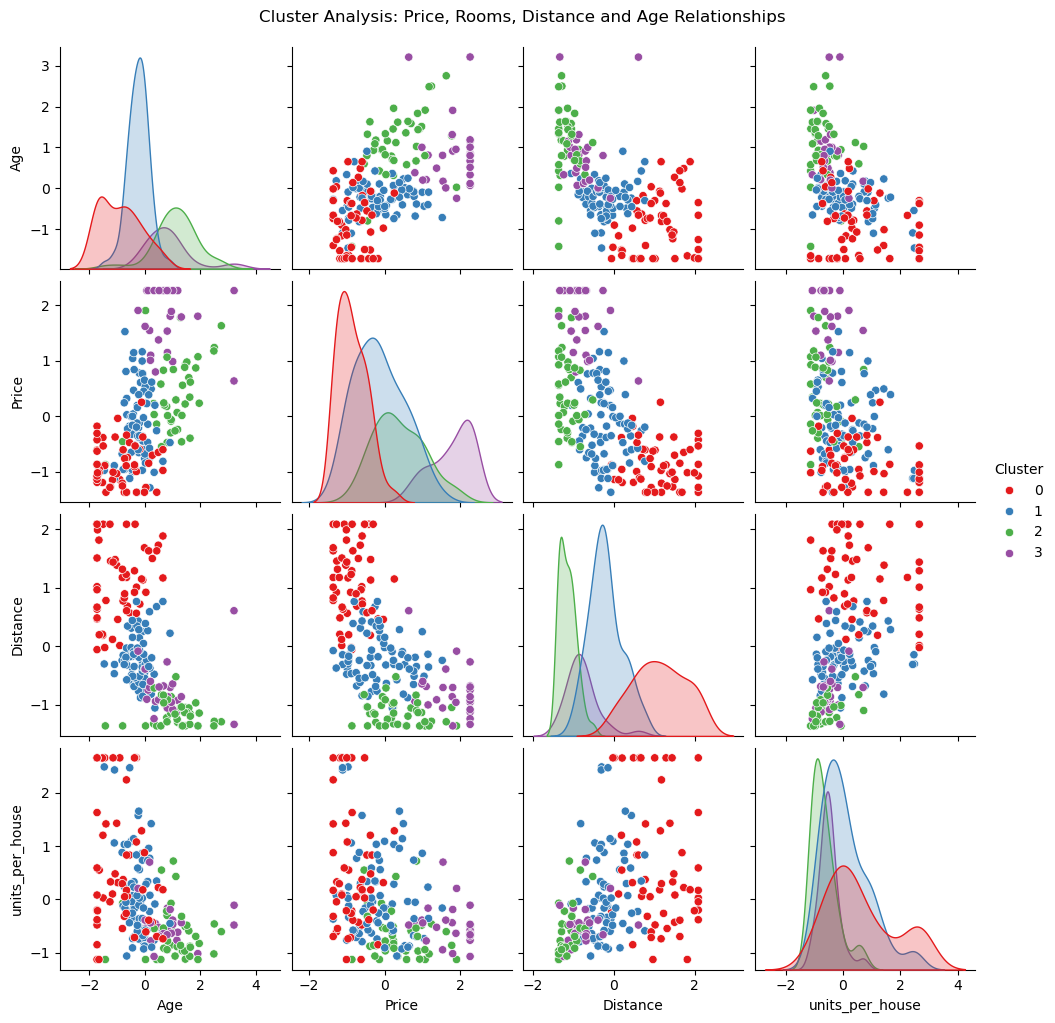

In [353]:
# Create pairplot with clearer colors
plt.figure(figsize=(12, 8))
sns.pairplot(features2, hue='Cluster', palette='Set1')
plt.suptitle('Cluster Analysis: Price, Rooms, Distance and Age Relationships', y=1.02)
plt.show()

We see that as expected the inner city areas have the least units per house. Due to the higher proportion of older houses which are less likely to install solar. 

Cluster 0 and Cluster 3 have clearly different mean age and units per house. We use theses for our significance testing.

In [138]:
features2['Cluster'].value_counts()


Cluster
2    53
1    50
3    50
0    46
Name: count, dtype: int64

Let the null hypothesis be that there is no statistical significance in the mean units per house for clusters 0 and 3. Then:

### Giving sensible names to the clusters based on the features

In [ ]:
# Newer outer suburbs
# Older outer suburbs
# Newer inner suburbs
# Older inner suburbs


In [354]:
from scipy.stats import ttest_ind

# Drop rows with missing units_per_house values
features_clean = features2.dropna(subset=['units_per_house'])

# Extract units_per_house values for each cluster
units_per_house_0 = features_clean[features_clean['Cluster'] == 0]['units_per_house']
units_per_house_3 = features_clean[features_clean['Cluster'] == 3]['units_per_house']

# Compute group means
mean_0 = units_per_house_0.mean()
mean_3 = units_per_house_3.mean()

# Perform Welch's t-test
t_stat, p_val = ttest_ind(units_per_house_0, units_per_house_3, equal_var=False)

# Display results
print(f"Cluster 0 mean units per house: {mean_0:.2f}")
print(f"Cluster 3 mean units per house: {mean_3:.2f}")
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_val:.4f}")


Cluster 0 mean units per house: 0.62
Cluster 3 mean units per house: -0.49
T-statistic: 6.38
P-value: 0.0000


## Conclusion

We reject the null hypothesis as the P-value is less than 0.05. The T-statistic of 2.64 indicates a moderate to strong effect size.

We assume that of all the factors, age of the house, is the biggest factor affecting solar adoption. However, this is not confirmed statistically, rather just a hypothesis based on the above visual.

So far, we have looked at the house features which would be likely to affect solar adoption. It is recommended to do further analysis with ABS data relating to the individual buyers. For example, disposable income may be a bigger factor influencing solar adoption.

The analysis could also be done with different machine learninig models and more visual techniques such as a 3d map which could highlight more features.

## References

**Data Sources**

Australian Bureau of Statistics (2021). Postal Areas 2021 - Australia (Digital Boundaries). ABS. Retrieved from: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files

Victorian Government (2023). Melbourne House Prices Dataset. Department of Environment, Land, Water and Planning.
Victorian Government (2023). Melbourne Housing Full Dataset. Department of Environment, Land, Water and Planning.
Victorian Government (2023). Solar Capacity Data 2011 to Present. Sustainability Victoria. Retrieved from: https://www.sustainability.vic.gov.au/

Victorian Government (2023). Solar Installations Data 2011 to Present. Sustainability Victoria. Retrieved from: https://www.sustainability.vic.gov.au/

**Software and Libraries**

Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95.
McKinney, W. (2010). Data structures for statistical computing in Python. Proceedings of the 9th Python in Science Conference, 51-56.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830.

Waskom, M. L. (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021.
Jordahl, K., den Bossche, J. V., Fleischmann, M., Wasserman, J., McBride, J., Gerard, J., ... & Leblanc, F. (2020). GeoPandas: Python tools for geographic data. Retrieved from: https://geopandas.org/